In [164]:
import warnings
warnings.simplefilter("ignore")

In [165]:
from datetime import date
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [166]:
import duckdb

In [167]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import ADASYN

In [168]:
from sklearn.dummy import DummyClassifier
from lightgbm import LGBMClassifier

In [169]:
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, accuracy_score, roc_auc_score

In [170]:
import shap

# 1. Import data

app interaction

In [171]:
app_interaction_df = pd.read_csv('Application_Usage_Data.csv')

In [172]:
app_interaction_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197206 entries, 0 to 1197205
Data columns (total 3 columns):
 #   Column    Non-Null Count    Dtype 
---  ------    --------------    ----- 
 0   id        1197206 non-null  int64 
 1   datetime  1197206 non-null  object
 2   action    1197206 non-null  object
dtypes: int64(1), object(2)
memory usage: 27.4+ MB


In [173]:
app_interaction_df.head()

,id,datetime,action
0,1,2023-01-26 15:18:24,scroll
1,1,2023-11-14 07:21:31,save article
2,1,2023-06-24 01:44:07,save article
3,1,2023-11-13 23:05:55,click ad
4,1,2023-03-20 00:08:18,scroll


In [174]:
app_interaction_df['datetime'] = pd.to_datetime(app_interaction_df['datetime'], format='mixed')

In [175]:
app_interaction_df['action'].unique()

array(['scroll', 'save article', 'click ad', 'like post', 'search',
       'open news', 'share article', 'view comments', 'read economics',
       'click video'], dtype=object)

In [176]:
app_interaction_df = duckdb.query("""
select id
, date_trunc('month', datetime::date) + interval '1 month' - interval '1 day' AS datetime
, case when action = 'read economics' then 1 else 0 end as read_econ
, case when action = 'article' then 1 else 0 end as share_article
, case when action = 'click ad' then 1 else 0 end as click_ads
, case when action = 'click video' then 1 else 0 end as click_video
, case when action = 'save article' then 1 else 0 end as save_article
, case when action = 'like post' then 1 else 0 end as like_post
, case when action = 'scroll' then 1 else 0 end as scroll
, case when action = 'search' then 1 else 0 end as search
, case when action = 'view comments' then 1 else 0 end as view_comment
, case when action = 'open news' then 1 else 0 end as open_news
from app_interaction_df
""").to_df()

In [177]:
app_interaction_df.head()

,id,datetime,read_econ,share_article,click_ads,click_video,save_article,like_post,scroll,search,view_comment,open_news
0,1,2023-01-31,0,0,0,0,0,0,1,0,0,0
1,1,2023-11-30,0,0,0,0,1,0,0,0,0,0
2,1,2023-06-30,0,0,0,0,1,0,0,0,0,0
3,1,2023-11-30,0,0,1,0,0,0,0,0,0,0
4,1,2023-03-31,0,0,0,0,0,0,1,0,0,0


In [178]:
duckdb.query("""
select min(datetime) min_datetime
, max(datetime) max_datetime
from app_interaction_df
""").to_df()

,min_datetime,max_datetime
0,2023-01-31,2023-12-31


demographic

In [179]:
demo_df = pd.read_csv('Demographic_Data.csv')

In [180]:
demo_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        100000 non-null  int64 
 1   birthday  100000 non-null  object
 2   sex       100000 non-null  object
dtypes: int64(1), object(2)
memory usage: 2.3+ MB


In [181]:
demo_df['birthday'] = pd.to_datetime(demo_df['birthday'])

In [182]:
demo_df.head()

,id,birthday,sex
0,1,1966-08-23,Female
1,2,1972-08-20,Male
2,3,1989-04-15,Female
3,4,1973-12-26,Female
4,5,1966-02-09,Female


In [183]:
duckdb.query("""
select min(birthday) min_birthday
, max(birthday) max_birthday
from demo_df
""").to_df()

,min_birthday,max_birthday
0,1960-01-01,2004-12-31


sign up time

In [184]:
signup_df = pd.read_csv('Register_Time_Data.csv')

In [185]:
signup_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 2 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   id                 100000 non-null  int64 
 1   datetime_register  70021 non-null   object
dtypes: int64(1), object(1)
memory usage: 1.5+ MB


In [186]:
signup_df.dropna(inplace=True)

In [187]:
signup_df['datetime_register'] = pd.to_datetime(signup_df['datetime_register'])

In [188]:
signup_df = duckdb.query("""
select id
, date_trunc('month', datetime_register  ::date) + interval '1 month' - interval '1 day' AS datetime_register  
from signup_df
""").to_df()

In [189]:
signup_df = duckdb.query("""
select id
, min(datetime_register) datetime_register
from signup_df
group by id
""").to_df()

In [190]:
signup_df.head()

,id,datetime_register
0,70,2022-09-30
1,74,2022-11-30
2,107,2024-02-29
3,108,2023-11-30
4,124,2023-11-30


In [191]:
duckdb.query("""
select min(datetime_register) min_datetime_register
, max(datetime_register) max_datetime_register
from signup_df
""").to_df()

,min_datetime_register,max_datetime_register
0,2022-01-31,2024-03-31


# 2. Feature engineering

target extraction

In [192]:
duckdb.query("""
select min(datetime) min_datetime
, max(datetime) max_datetime
from app_interaction_df
""").to_df()

,min_datetime,max_datetime
0,2023-01-31,2023-12-31


In [193]:
# we will create target from '2023-03-31' to '2023-12-31' (3 months rolling windows)

In [194]:
target_df = duckdb.query("""
select a.id
, datetime
-- , datetime_register
, case when datetime = datetime_register then 1 else 0 end signup_flag
from
    (
    select distinct id
    from signup_df
    ) a 
left join
    (
    SELECT month_start + INTERVAL '1 month' - INTERVAL '1 day' AS datetime
    FROM 
    (SELECT DATE_TRUNC('month', generate_series) AS month_start
    FROM generate_series('2023-03-01'::DATE, '2023-10-31'::DATE, INTERVAL '1 month')) AS series
    ) b
on 1=1
left join
    (
    select id, datetime_register
    from signup_df
    ) c
on a.id = c.id
-- where a.id = '3'
-- and datetime_register >= datetime
""").to_df()

In [195]:
target_df.shape

(560168, 3)

In [196]:
target_df

,id,datetime,signup_flag
0,26,2023-03-31,0
1,32,2023-03-31,0
2,52,2023-03-31,0
3,55,2023-03-31,0
4,81,2023-03-31,0
...,...,...,...
560163,99968,2023-10-31,0
560164,99984,2023-10-31,0
560165,99985,2023-10-31,0
560166,99999,2023-10-31,0


<Axes: >

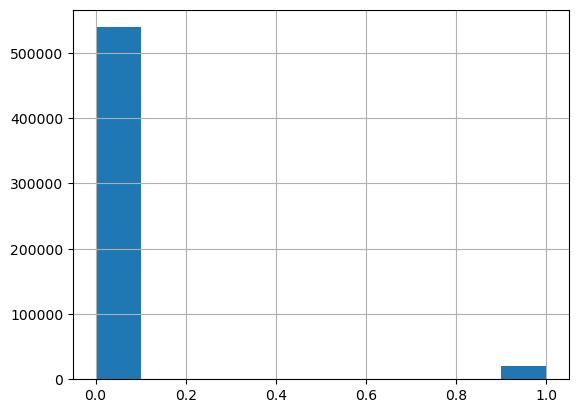

In [197]:
target_df['signup_flag'].hist()

feature extraction

In [198]:
def gen_feat_sum(feat_dt, app_usage):
    app_usage['tmp_date'] = pd.to_datetime(feat_dt)
    app_usage['day_diff'] = (app_usage['tmp_date'] - app_usage['datetime']).dt.days
    
    read_econ_1m = app_usage[app_usage['day_diff'].between(1, 30)].groupby('id').agg(sum_1m_read_econ=('read_econ', 'sum')).reset_index()
    share_article_1m = app_usage[app_usage['day_diff'].between(1, 30)].groupby('id').agg(sum_1m_share_article=('share_article', 'sum')).reset_index()
    click_ads_1m = app_usage[app_usage['day_diff'].between(1, 30)].groupby('id').agg(sum_1m_click_ads=('click_ads', 'sum')).reset_index()
    click_video_1m = app_usage[app_usage['day_diff'].between(1, 30)].groupby('id').agg(sum_1m_click_video=('click_video', 'sum')).reset_index()
    save_article_1m = app_usage[app_usage['day_diff'].between(1, 30)].groupby('id').agg(sum_1m_save_article=('save_article', 'sum')).reset_index()
    like_post_1m = app_usage[app_usage['day_diff'].between(1, 30)].groupby('id').agg(sum_1m_like_post=('like_post', 'sum')).reset_index()
    scroll_1m = app_usage[app_usage['day_diff'].between(1, 30)].groupby('id').agg(sum_1m_scroll=('scroll', 'sum')).reset_index()
    search_1m = app_usage[app_usage['day_diff'].between(1, 30)].groupby('id').agg(sum_1m_search=('search', 'sum')).reset_index()
    view_comment_1m = app_usage[app_usage['day_diff'].between(1, 30)].groupby('id').agg(sum_1m_view_comment=('view_comment', 'sum')).reset_index()
    open_news_1m = app_usage[app_usage['day_diff'].between(1, 30)].groupby('id').agg(sum_1m_open_news=('open_news', 'sum')).reset_index()

    read_econ_2m = app_usage[app_usage['day_diff'].between(1, 60)].groupby('id').agg(sum_2m_read_econ=('read_econ', 'sum')).reset_index()
    share_article_2m = app_usage[app_usage['day_diff'].between(1, 60)].groupby('id').agg(sum_2m_share_article=('share_article', 'sum')).reset_index()
    click_ads_2m = app_usage[app_usage['day_diff'].between(1, 60)].groupby('id').agg(sum_2m_click_ads=('click_ads', 'sum')).reset_index()
    click_video_2m = app_usage[app_usage['day_diff'].between(1, 60)].groupby('id').agg(sum_2m_click_video=('click_video', 'sum')).reset_index()
    save_article_2m = app_usage[app_usage['day_diff'].between(1, 60)].groupby('id').agg(sum_2m_save_article=('save_article', 'sum')).reset_index()
    like_post_2m = app_usage[app_usage['day_diff'].between(1, 60)].groupby('id').agg(sum_2m_like_post=('like_post', 'sum')).reset_index()
    scroll_2m = app_usage[app_usage['day_diff'].between(1, 60)].groupby('id').agg(sum_2m_scroll=('scroll', 'sum')).reset_index()
    search_2m = app_usage[app_usage['day_diff'].between(1, 60)].groupby('id').agg(sum_2m_search=('search', 'sum')).reset_index()
    view_comment_2m = app_usage[app_usage['day_diff'].between(1, 60)].groupby('id').agg(sum_2m_view_comment=('view_comment', 'sum')).reset_index()
    open_news_2m = app_usage[app_usage['day_diff'].between(1, 60)].groupby('id').agg(sum_2m_open_news=('open_news', 'sum')).reset_index()

    read_econ_3m = app_usage[app_usage['day_diff'].between(1, 90)].groupby('id').agg(sum_3m_read_econ=('read_econ', 'sum')).reset_index()
    share_article_3m = app_usage[app_usage['day_diff'].between(1, 90)].groupby('id').agg(sum_3m_share_article=('share_article', 'sum')).reset_index()
    click_ads_3m = app_usage[app_usage['day_diff'].between(1, 90)].groupby('id').agg(sum_3m_click_ads=('click_ads', 'sum')).reset_index()
    click_video_3m = app_usage[app_usage['day_diff'].between(1, 90)].groupby('id').agg(sum_3m_click_video=('click_video', 'sum')).reset_index()
    save_article_3m = app_usage[app_usage['day_diff'].between(1, 90)].groupby('id').agg(sum_3m_save_article=('save_article', 'sum')).reset_index()
    like_post_3m = app_usage[app_usage['day_diff'].between(1, 90)].groupby('id').agg(sum_3m_like_post=('like_post', 'sum')).reset_index()
    scroll_3m = app_usage[app_usage['day_diff'].between(1, 90)].groupby('id').agg(sum_3m_scroll=('scroll', 'sum')).reset_index()
    search_3m = app_usage[app_usage['day_diff'].between(1, 90)].groupby('id').agg(sum_3m_search=('search', 'sum')).reset_index()
    view_comment_3m = app_usage[app_usage['day_diff'].between(1, 90)].groupby('id').agg(sum_3m_view_comment=('view_comment', 'sum')).reset_index()
    open_news_3m = app_usage[app_usage['day_diff'].between(1, 90)].groupby('id').agg(sum_3m_open_news=('open_news', 'sum')).reset_index()

    result = read_econ_1m
    result = result.merge(share_article_1m, on='id', how='left')
    result = result.merge(click_ads_1m, on='id', how='left')
    result = result.merge(click_video_1m, on='id', how='left')
    result = result.merge(save_article_1m, on='id', how='left')
    result = result.merge(like_post_1m, on='id', how='left')
    result = result.merge(scroll_1m, on='id', how='left')
    result = result.merge(search_1m, on='id', how='left')
    result = result.merge(view_comment_1m, on='id', how='left')
    result = result.merge(open_news_1m, on='id', how='left')

    result = result.merge(read_econ_2m, on='id', how='left')
    result = result.merge(share_article_2m, on='id', how='left')
    result = result.merge(click_ads_2m, on='id', how='left')
    result = result.merge(click_video_2m, on='id', how='left')
    result = result.merge(save_article_2m, on='id', how='left')
    result = result.merge(like_post_2m, on='id', how='left')
    result = result.merge(scroll_2m, on='id', how='left')
    result = result.merge(search_2m, on='id', how='left')
    result = result.merge(view_comment_2m, on='id', how='left')
    result = result.merge(open_news_2m, on='id', how='left')

    result = result.merge(read_econ_3m, on='id', how='left')
    result = result.merge(share_article_3m, on='id', how='left')
    result = result.merge(click_ads_3m, on='id', how='left')
    result = result.merge(click_video_3m, on='id', how='left')
    result = result.merge(save_article_3m, on='id', how='left')
    result = result.merge(like_post_3m, on='id', how='left')
    result = result.merge(scroll_3m, on='id', how='left')
    result = result.merge(search_3m, on='id', how='left')
    result = result.merge(view_comment_3m, on='id', how='left')
    result = result.merge(open_news_3m, on='id', how='left')

    result = result.merge(app_usage[['id', 'tmp_date']].drop_duplicates(), on='id', how='left')

    result.fillna(0, inplace=True)

    return result

In [199]:
def gen_feat_demo(feat_dt, demo):
    demo['tmp_date'] = feat_dt
    demo['tmp_date'] = pd.to_datetime(demo['tmp_date'])

    demo['age'] = (demo['tmp_date'] - demo['birthday']).dt.days/360

    demo['sex'] = np.where(demo['sex'] == 'M', 1, 0)
    
    demo.fillna(0, inplace=True)
    result = demo[['id','sex','age','tmp_date']]
    
    return result

In [200]:
usage_feat1 = gen_feat_sum(feat_dt=date(2023, 3, 30), app_usage=app_interaction_df)
usage_feat2 = gen_feat_sum(feat_dt=date(2023, 4, 30), app_usage=app_interaction_df)
usage_feat3 = gen_feat_sum(feat_dt=date(2023, 5, 31), app_usage=app_interaction_df)
usage_feat4 = gen_feat_sum(feat_dt=date(2023, 6, 30), app_usage=app_interaction_df)
usage_feat5 = gen_feat_sum(feat_dt=date(2023, 7, 31), app_usage=app_interaction_df)
usage_feat6 = gen_feat_sum(feat_dt=date(2023, 8, 31), app_usage=app_interaction_df)
usage_feat7 = gen_feat_sum(feat_dt=date(2023, 9, 30), app_usage=app_interaction_df)
usage_feat8 = gen_feat_sum(feat_dt=date(2023, 10, 31), app_usage=app_interaction_df)
usage_feat9 = gen_feat_sum(feat_dt=date(2023, 11, 30), app_usage=app_interaction_df)
usage_feat10 = gen_feat_sum(feat_dt=date(2023, 12, 31), app_usage=app_interaction_df)

In [201]:
all_usage_features = pd.concat([usage_feat1, usage_feat2, usage_feat3, usage_feat4, usage_feat5, usage_feat6, usage_feat7, usage_feat8, usage_feat9, usage_feat10], ignore_index=True)

In [202]:
all_usage_features.columns

Index(['id', 'sum_1m_read_econ', 'sum_1m_share_article', 'sum_1m_click_ads',
       'sum_1m_click_video', 'sum_1m_save_article', 'sum_1m_like_post',
       'sum_1m_scroll', 'sum_1m_search', 'sum_1m_view_comment',
       'sum_1m_open_news', 'sum_2m_read_econ', 'sum_2m_share_article',
       'sum_2m_click_ads', 'sum_2m_click_video', 'sum_2m_save_article',
       'sum_2m_like_post', 'sum_2m_scroll', 'sum_2m_search',
       'sum_2m_view_comment', 'sum_2m_open_news', 'sum_3m_read_econ',
       'sum_3m_share_article', 'sum_3m_click_ads', 'sum_3m_click_video',
       'sum_3m_save_article', 'sum_3m_like_post', 'sum_3m_scroll',
       'sum_3m_search', 'sum_3m_view_comment', 'sum_3m_open_news', 'tmp_date'],
      dtype='object')

In [203]:
demo_feat1 = gen_feat_demo(feat_dt=date(2023, 3, 30), demo=demo_df)
demo_feat2 = gen_feat_demo(feat_dt=date(2023, 4, 30), demo=demo_df)
demo_feat3 = gen_feat_demo(feat_dt=date(2023, 5, 31), demo=demo_df)
demo_feat4 = gen_feat_demo(feat_dt=date(2023, 6, 30), demo=demo_df)
demo_feat5 = gen_feat_demo(feat_dt=date(2023, 7, 31), demo=demo_df)
demo_feat6 = gen_feat_demo(feat_dt=date(2023, 8, 31), demo=demo_df)
demo_feat7 = gen_feat_demo(feat_dt=date(2023, 9, 30), demo=demo_df)
demo_feat8 = gen_feat_demo(feat_dt=date(2023, 10, 31), demo=demo_df)
demo_feat9 = gen_feat_demo(feat_dt=date(2023, 11, 30), demo=demo_df)
demo_feat10 = gen_feat_demo(feat_dt=date(2023, 12, 31), demo=demo_df)

In [204]:
all_demo_features = pd.concat([demo_feat1, demo_feat2, demo_feat3, demo_feat4, demo_feat5, demo_feat6, demo_feat7, demo_feat8, demo_feat9, demo_feat10], ignore_index=True)

In [205]:
all_demo_features.columns

Index(['id', 'sex', 'age', 'tmp_date'], dtype='object')

In [206]:
df = duckdb.query("""
select a.*
, sum_1m_read_econ, sum_1m_share_article, sum_1m_click_ads, sum_1m_click_video, sum_1m_save_article, sum_1m_like_post, sum_1m_scroll, sum_1m_search, sum_1m_view_comment, sum_1m_open_news
, sum_2m_read_econ, sum_2m_share_article, sum_2m_click_ads, sum_2m_click_video, sum_2m_save_article, sum_2m_like_post, sum_2m_scroll, sum_2m_search, sum_2m_view_comment, sum_2m_open_news
, sum_3m_read_econ, sum_3m_share_article, sum_3m_click_ads, sum_3m_click_video, sum_3m_save_article, sum_3m_like_post, sum_3m_scroll, sum_3m_search, sum_3m_view_comment, sum_3m_open_news
, sex, age
from target_df a
left join all_usage_features b
on (a.id = b.id) and (a.datetime = b.tmp_date)
left join all_demo_features c
on (a.id = c.id) and (a.datetime = c.tmp_date)
where a.datetime >= '2023-04-01'
""").to_df()

In [207]:
df.fillna(0,inplace=True)

In [208]:
df.shape

(490147, 35)

In [209]:
df.head()

,id,datetime,signup_flag,sum_1m_read_econ,sum_1m_share_article,sum_1m_click_ads,sum_1m_click_video,sum_1m_save_article,sum_1m_like_post,sum_1m_scroll,...,sum_3m_click_ads,sum_3m_click_video,sum_3m_save_article,sum_3m_like_post,sum_3m_scroll,sum_3m_search,sum_3m_view_comment,sum_3m_open_news,sex,age
0,1,2023-04-30,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,3.0,0.0,0.0,1.0,0,57.511111
1,2,2023-04-30,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,51.430556
2,3,2023-04-30,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,34.536111
3,4,2023-04-30,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,50.061111
4,6,2023-04-30,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,47.188889


In [212]:
df.to_csv('s.csv')

In [210]:
**

SyntaxError: invalid syntax (402238255.py, line 1)

In [ ]:
# data generated by ChatGPT, its hard to generated data with high correlation, so i show the way to feature engineered then i will replace it by others data set that have much correlation tro predict

In [216]:
df = pd.read_csv('s.csv')

In [217]:
df['datetime'] = pd.to_datetime(app_interaction_df['datetime'], format='mixed')

In [218]:
df

,signup_flag,sum_1m_read_econ,sum_1m_share_article,sum_1m_click_ads,sum_1m_click_video,sum_1m_save_article,sum_1m_like_post,sum_1m_scroll,sum_1m_search,sum_1m_view_comment,...,sum_3m_click_video,sum_3m_save_article,sum_3m_like_post,sum_3m_scroll,sum_3m_search,sum_3m_view_comment,sum_3m_open_news,sex,age,datetime
0,0,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,2023-01-31
1,0,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,2023-11-30
2,0,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,0,2023-06-30
3,0,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,2023-11-30
4,0,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,2023-03-31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
490142,0,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,0,2023-01-31
490143,0,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,0,2023-12-31
490144,0,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,2023-11-30
490145,0,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,2023-08-31


# 3. Exploratory data analysis (EDA)

In [219]:
id_col = ['id']

In [220]:
target_col = ['signup_flag']

In [221]:
num_col = ['sum_1m_read_econ', 'sum_1m_share_article', 'sum_1m_click_ads',
       'sum_1m_click_video', 'sum_1m_save_article', 'sum_1m_like_post',
       'sum_1m_scroll', 'sum_1m_search', 'sum_1m_view_comment',
       'sum_1m_open_news', 'sum_2m_read_econ', 'sum_2m_share_article',
       'sum_2m_click_ads', 'sum_2m_click_video', 'sum_2m_save_article',
       'sum_2m_like_post', 'sum_2m_scroll', 'sum_2m_search',
       'sum_2m_view_comment', 'sum_2m_open_news', 'sum_3m_read_econ',
       'sum_3m_share_article', 'sum_3m_click_ads', 'sum_3m_click_video',
       'sum_3m_save_article', 'sum_3m_like_post', 'sum_3m_scroll',
       'sum_3m_search', 'sum_3m_view_comment', 'sum_3m_open_news', 'sex', 'age']

target

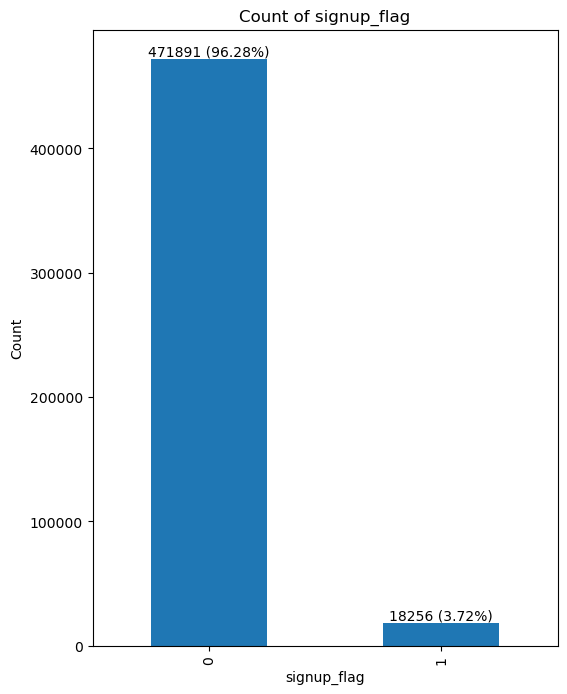

In [222]:
for column in target_col:
    category_counts = df[column].value_counts()
    total_count = len(df[column])
    plt.figure(figsize=(6, 8))
    ax = category_counts.plot(kind='bar')
    for i, count in enumerate(category_counts):
        percentage = (count / total_count) * 100
        ax.annotate(f'{count} ({percentage:.2f}%)', xy=(i, count), ha='center', va='bottom')
    
    plt.xlabel(column)
    plt.ylabel('Count')
    plt.title(f'Count of {column}')
    plt.show()

numerical features

In [223]:
df[num_col].describe()

,sum_1m_read_econ,sum_1m_share_article,sum_1m_click_ads,sum_1m_click_video,sum_1m_save_article,sum_1m_like_post,sum_1m_scroll,sum_1m_search,sum_1m_view_comment,sum_1m_open_news,...,sum_3m_click_ads,sum_3m_click_video,sum_3m_save_article,sum_3m_like_post,sum_3m_scroll,sum_3m_search,sum_3m_view_comment,sum_3m_open_news,sex,age
count,490147.0,490147.0,490147.0,490147.0,490147.0,490147.0,490147.0,490147.0,490147.0,490147.0,...,490147.0,490147.0,490147.0,490147.0,490147.0,490147.0,490147.0,490147.0,490147.0,490147.000000
mean,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.504002
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.499984
min,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000
25%,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000
50%,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000
75%,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000
max,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000


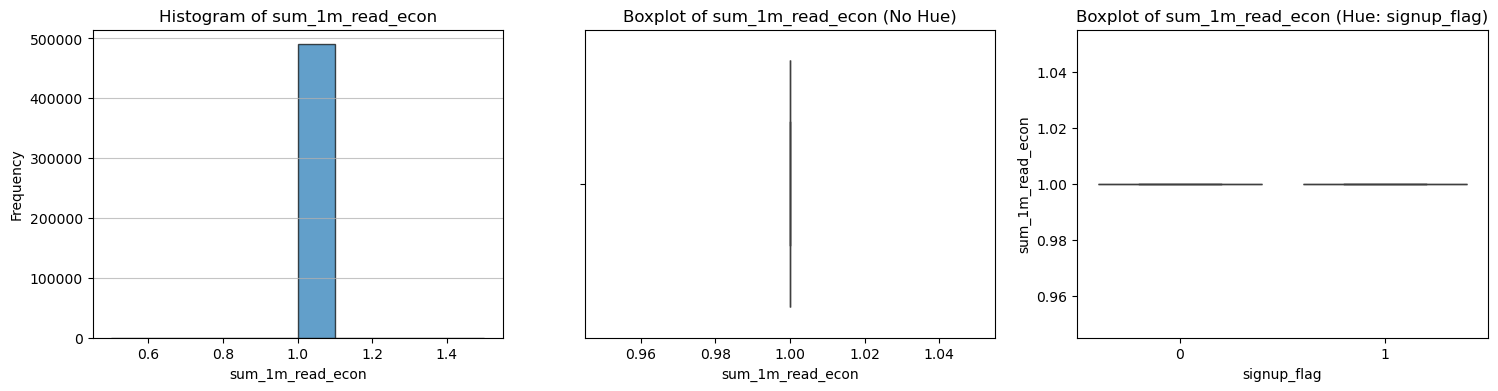

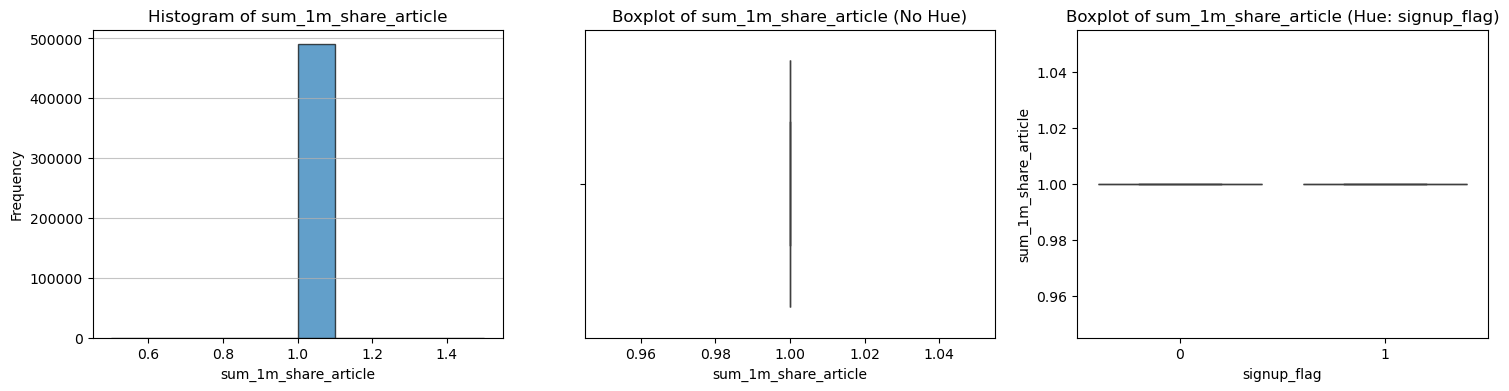

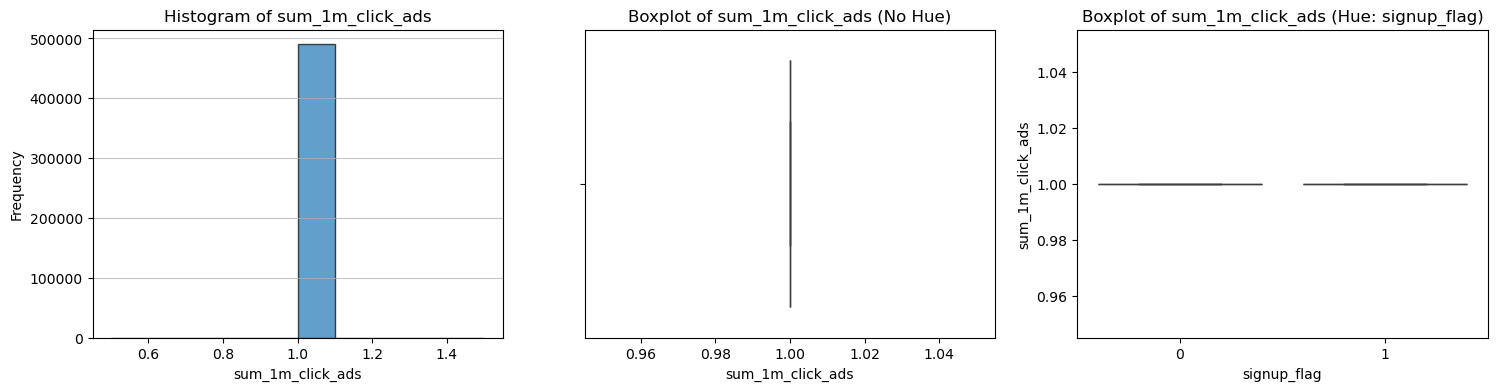

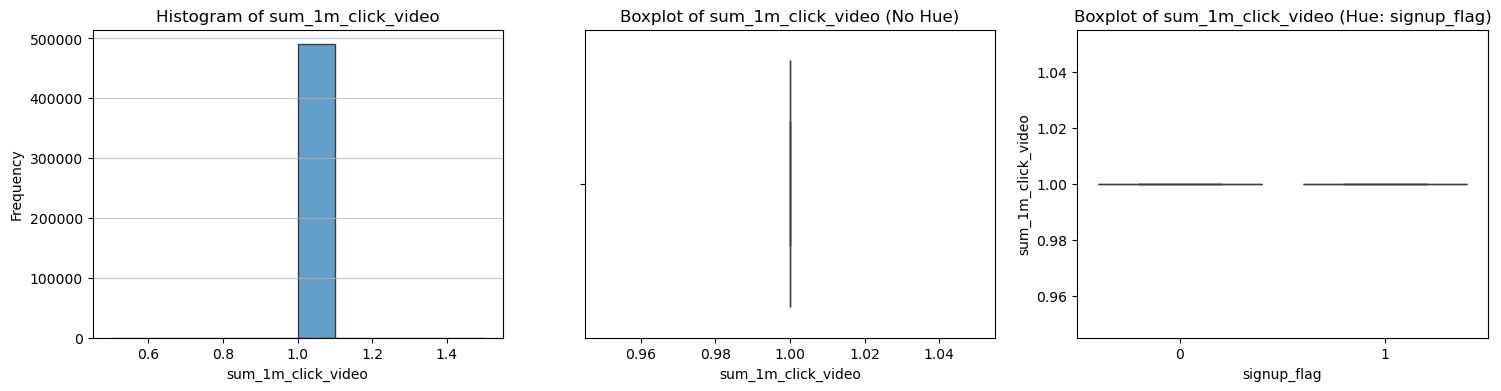

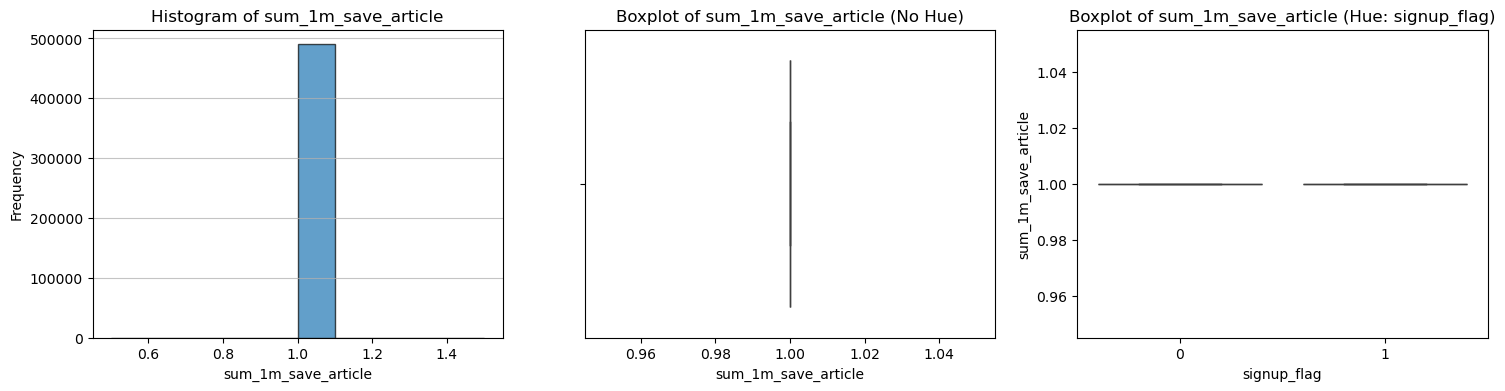

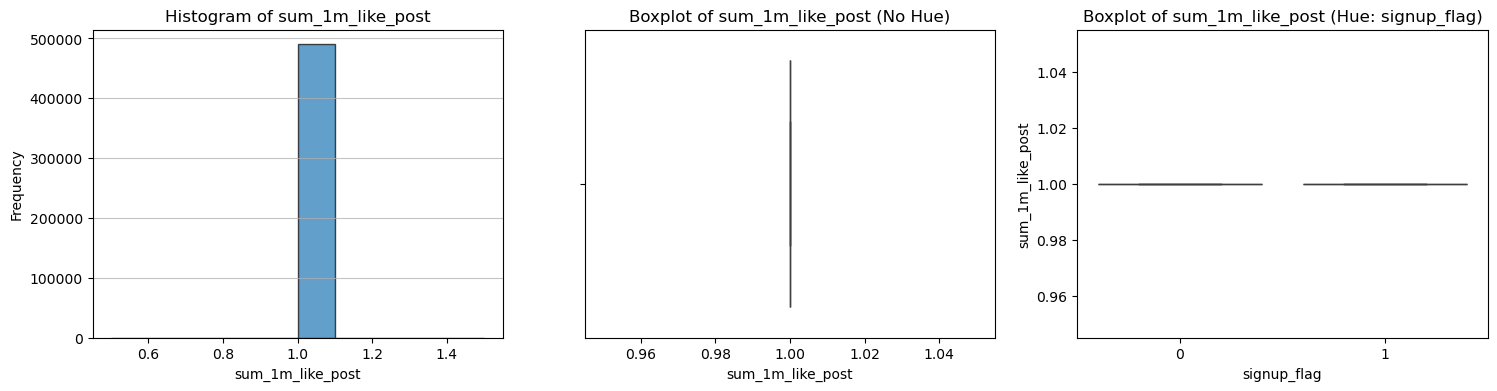

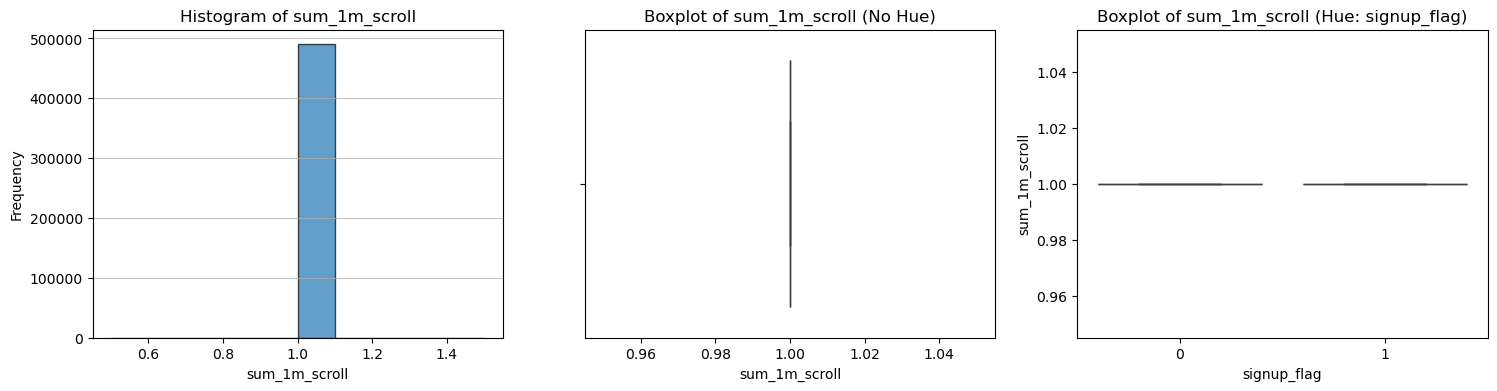

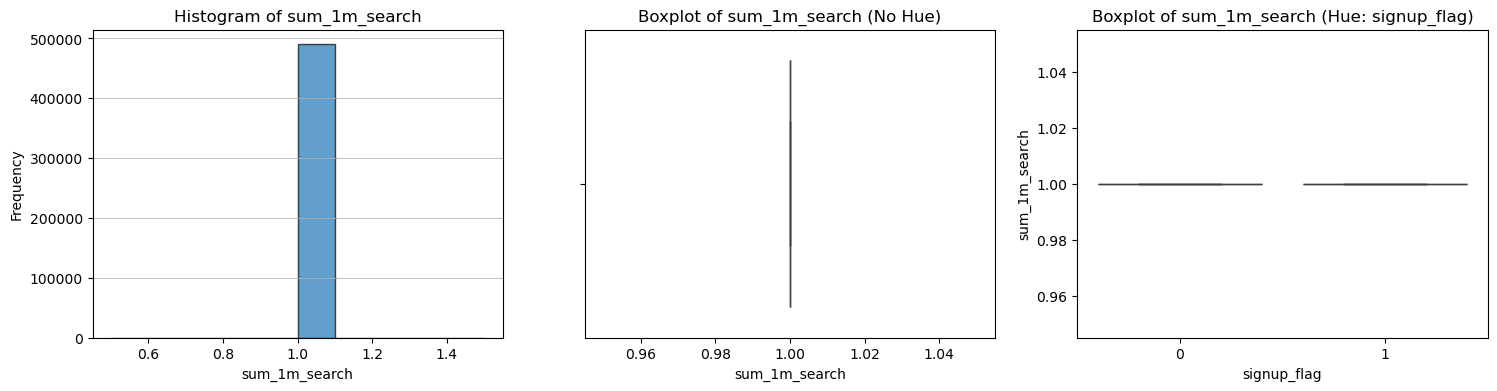

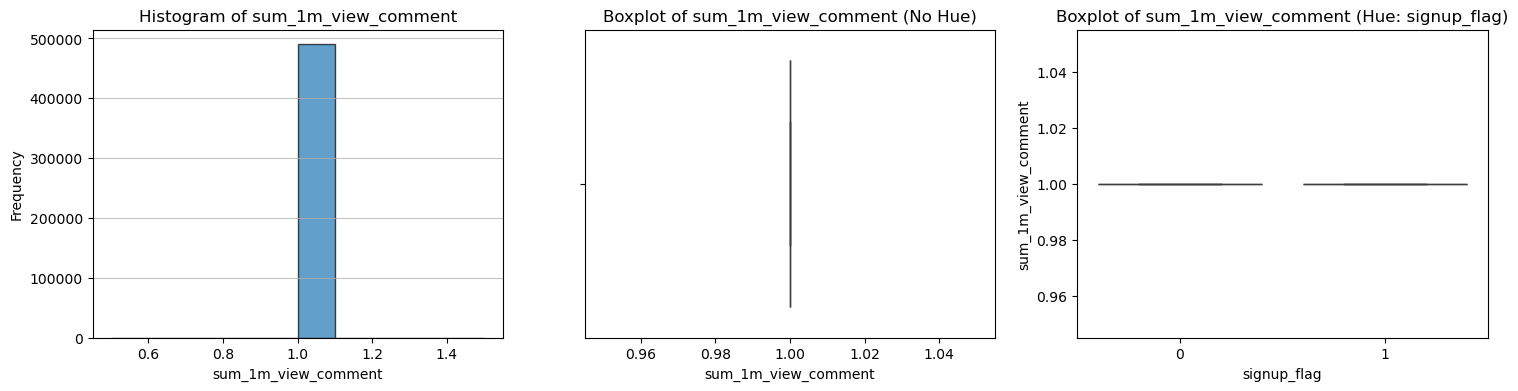

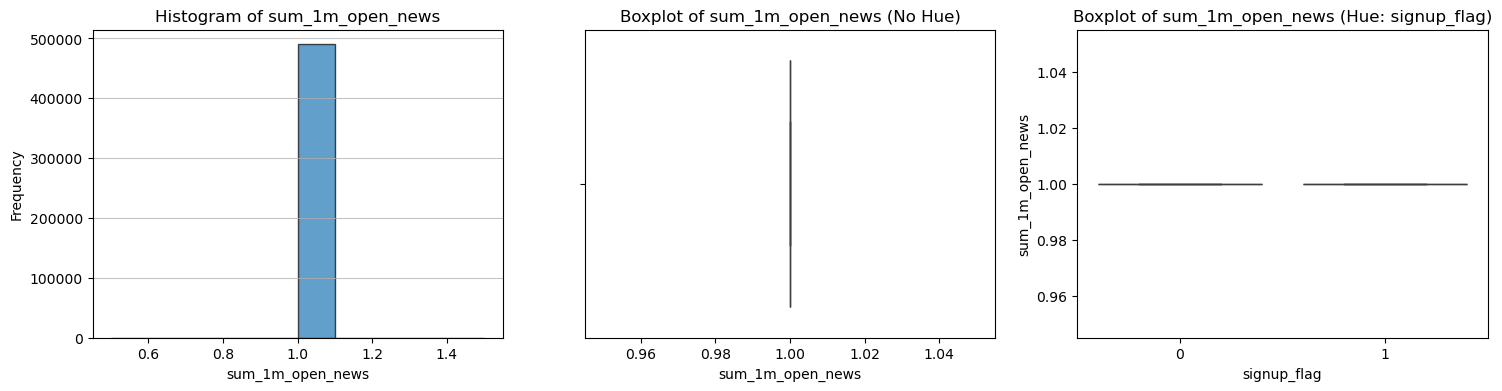

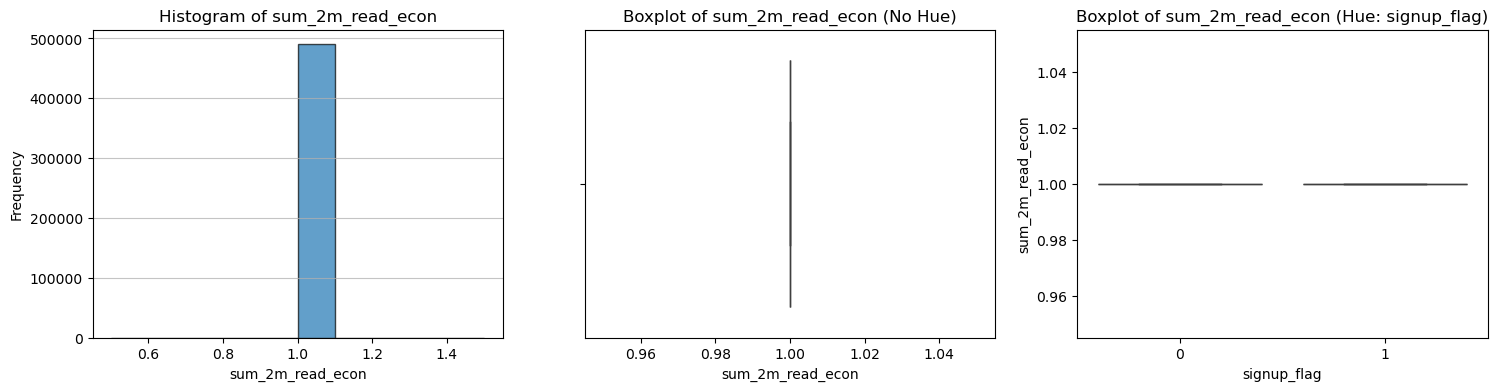

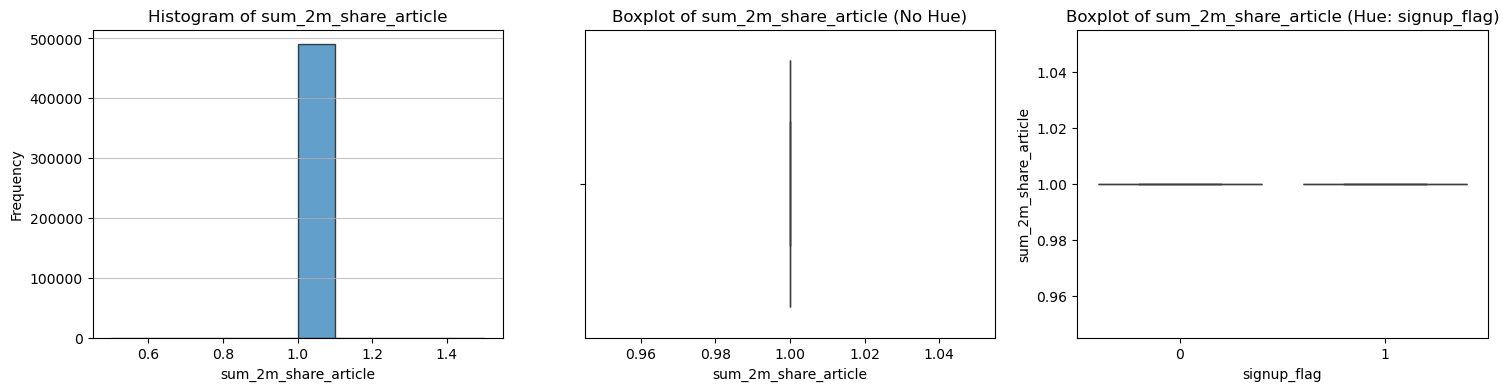

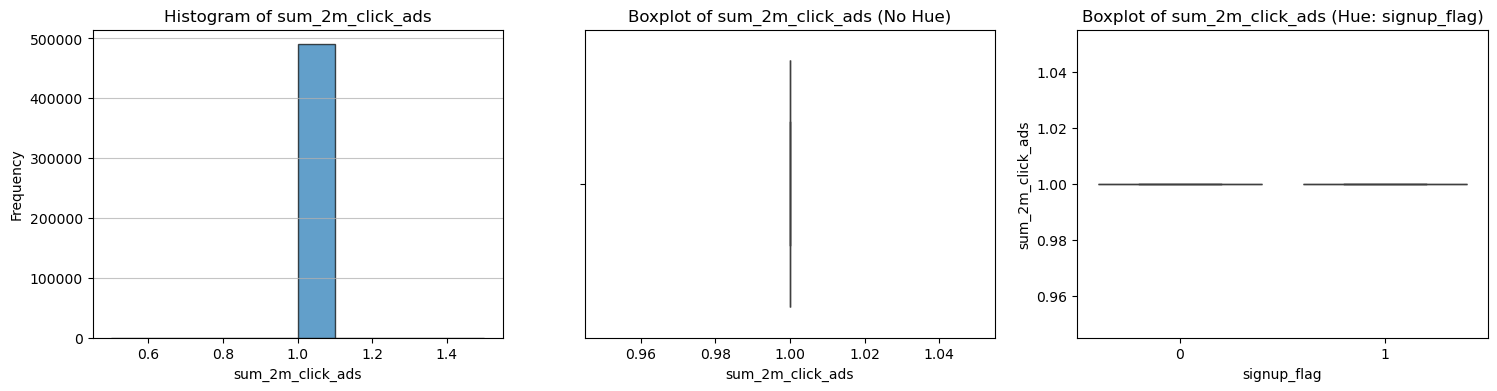

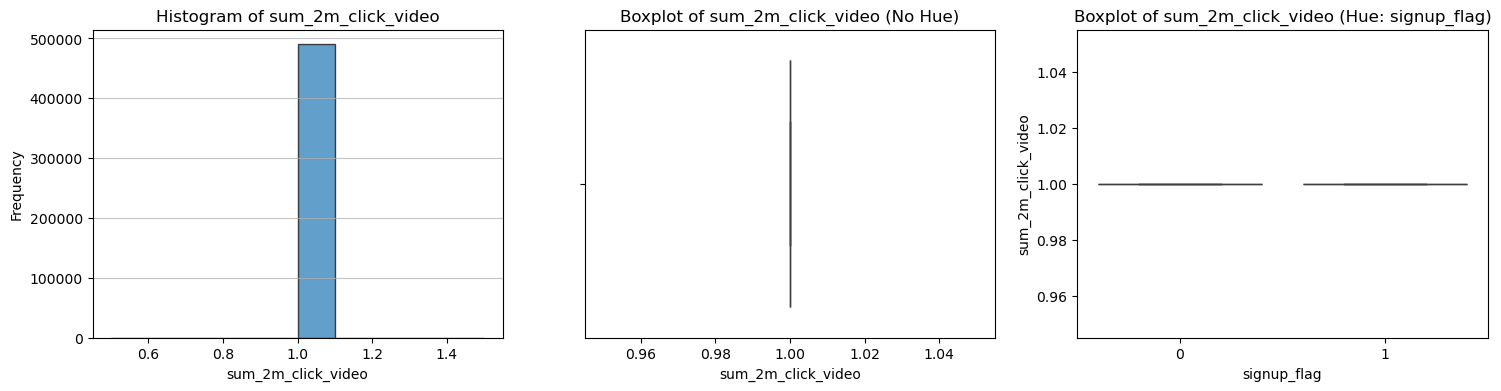

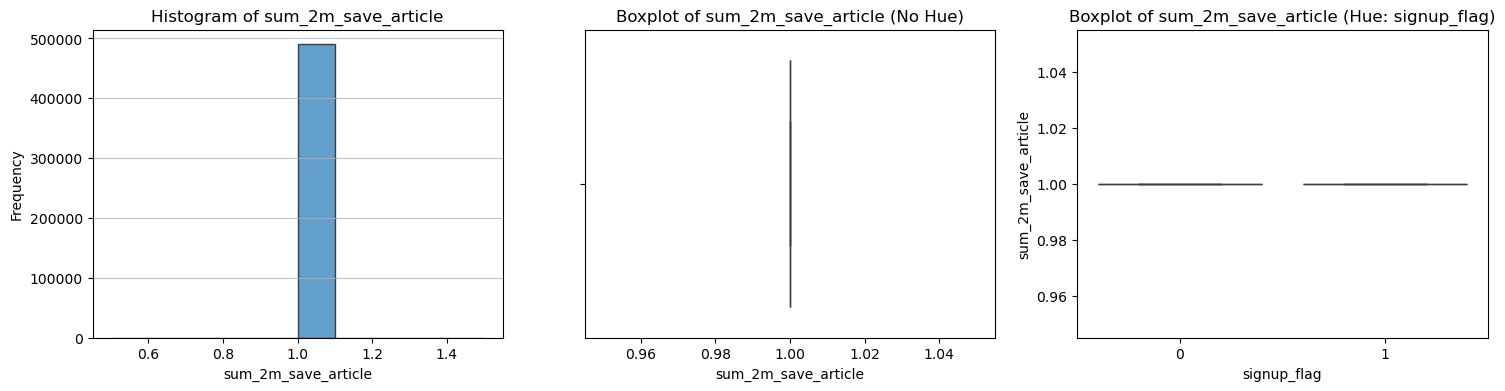

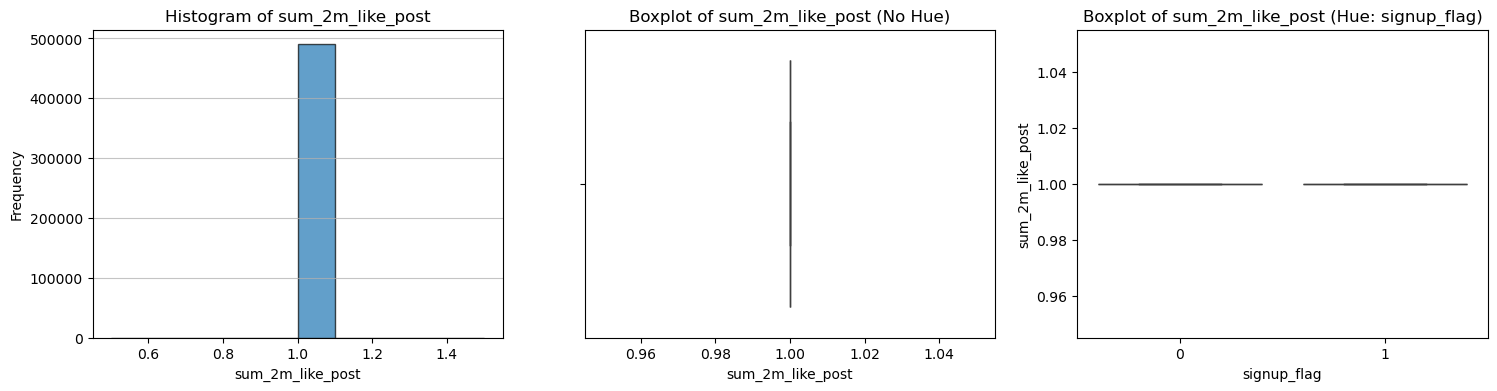

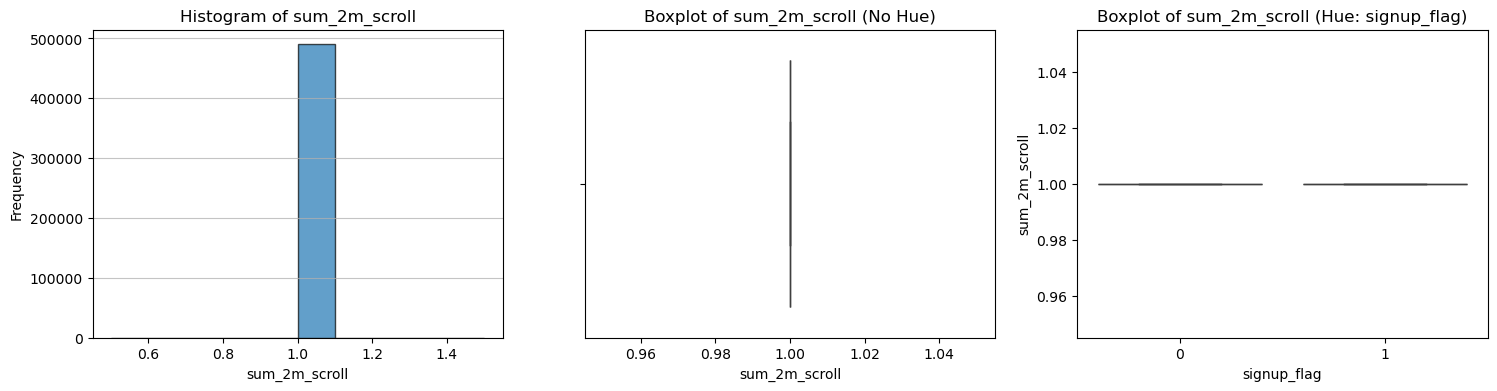

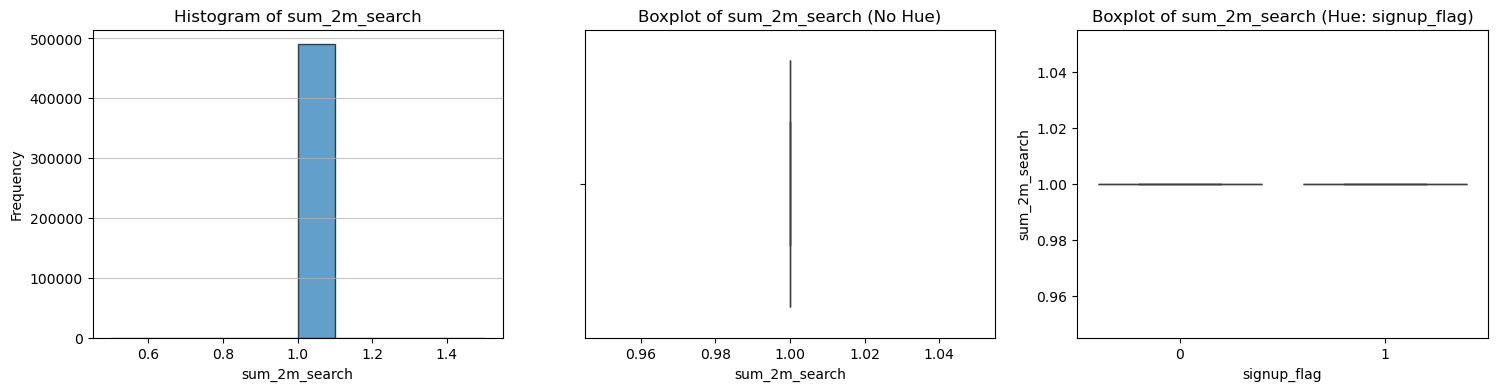

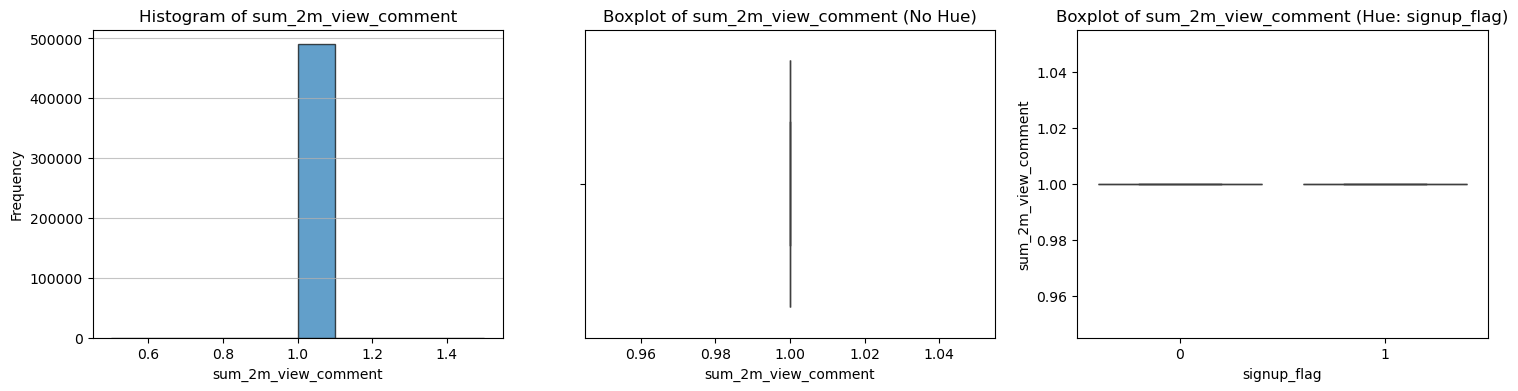

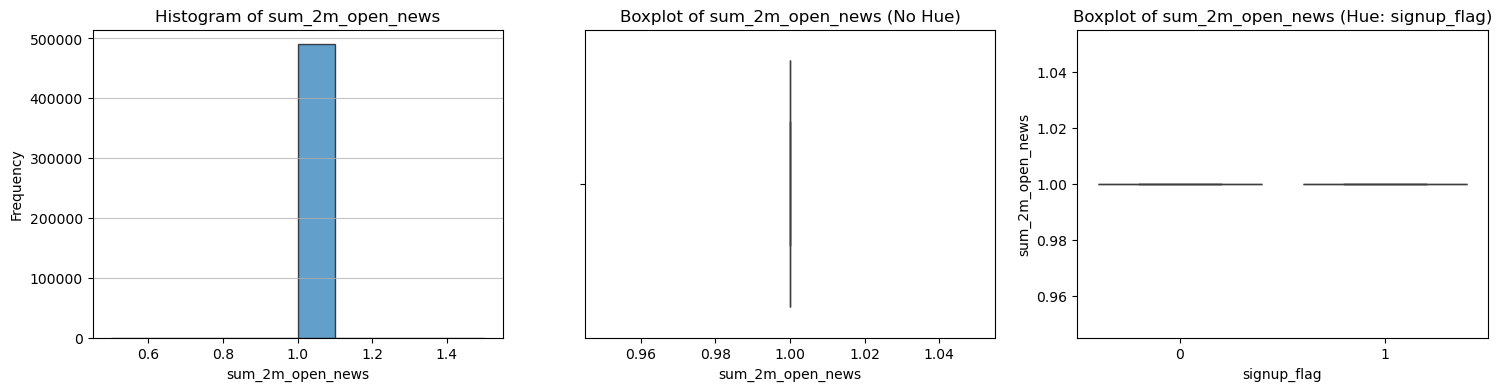

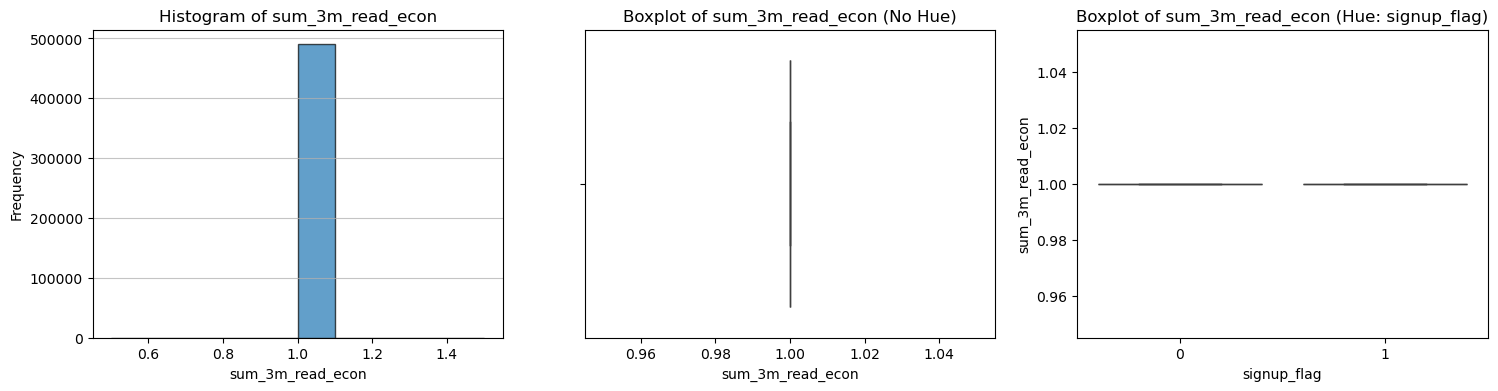

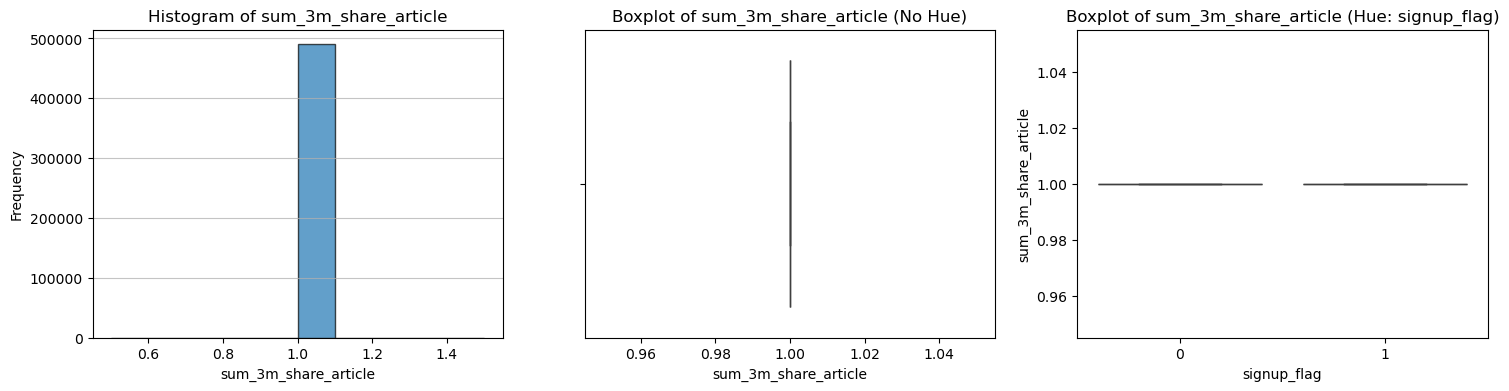

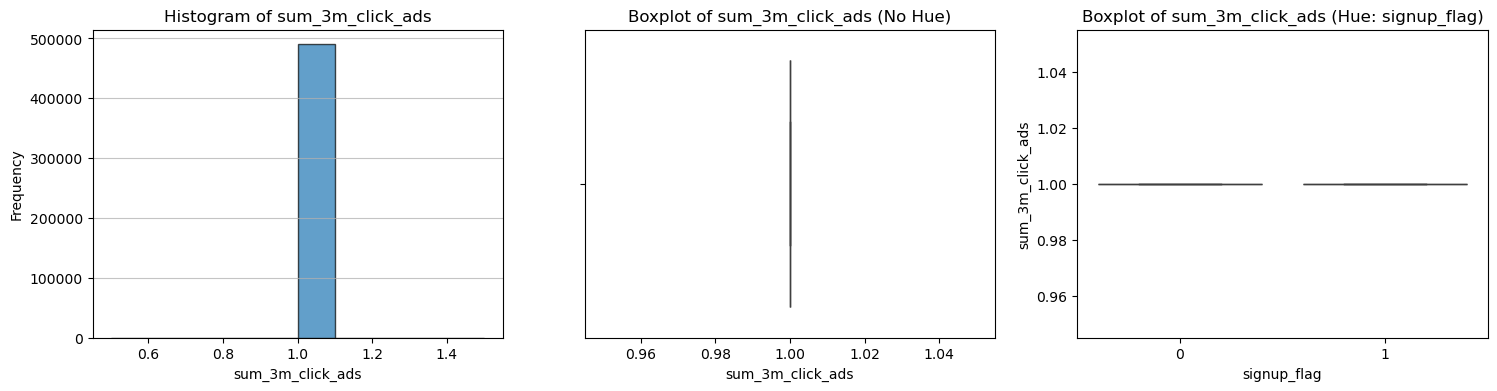

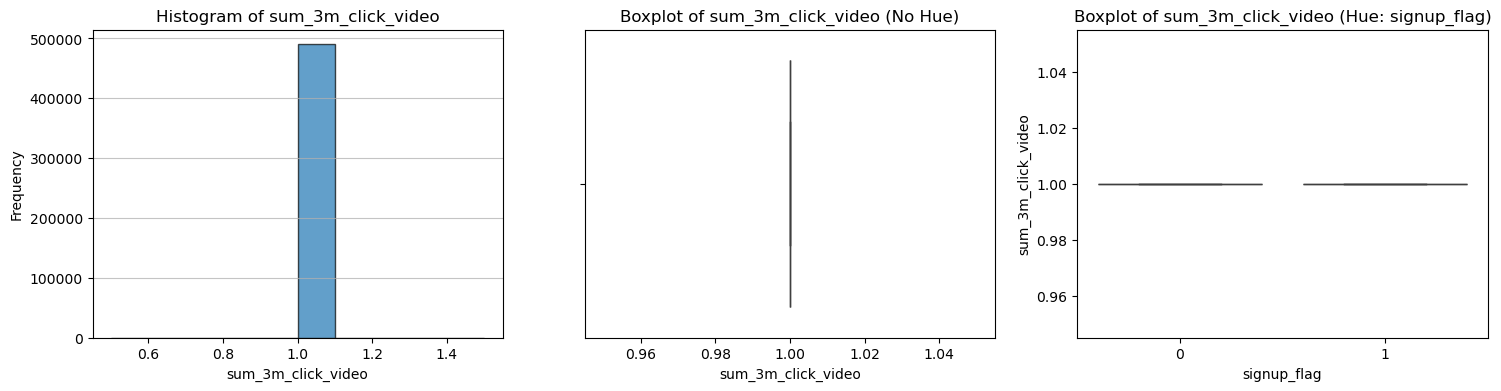

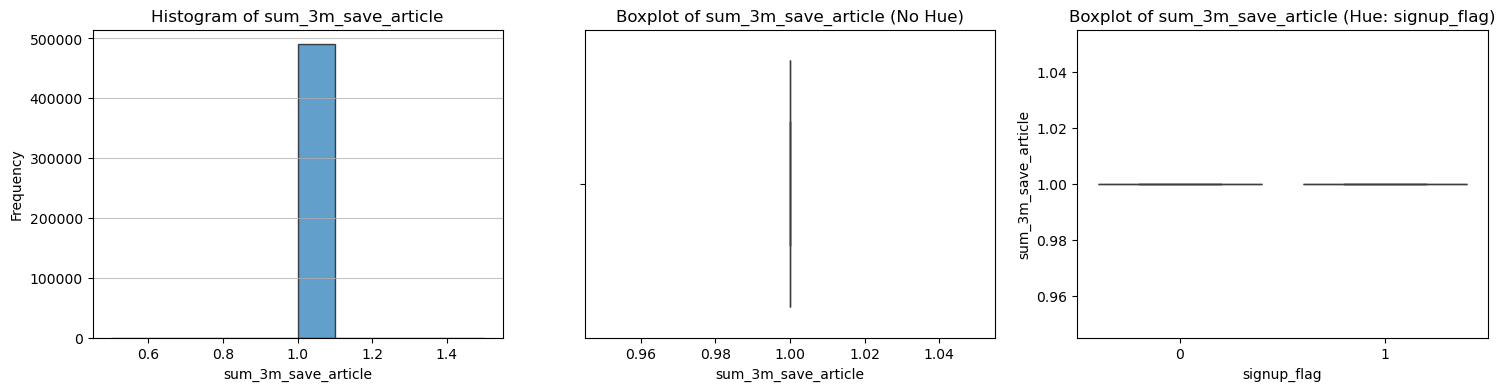

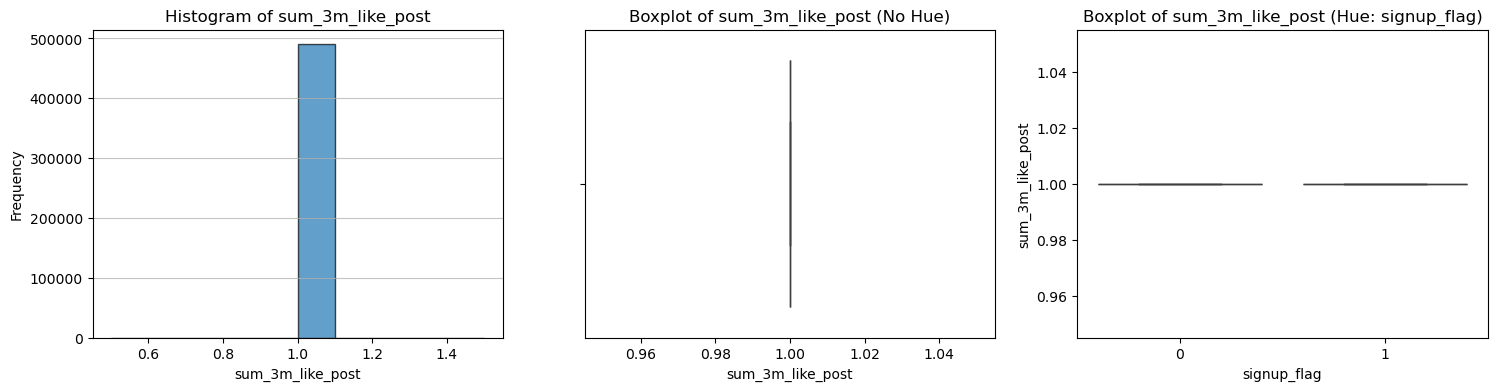

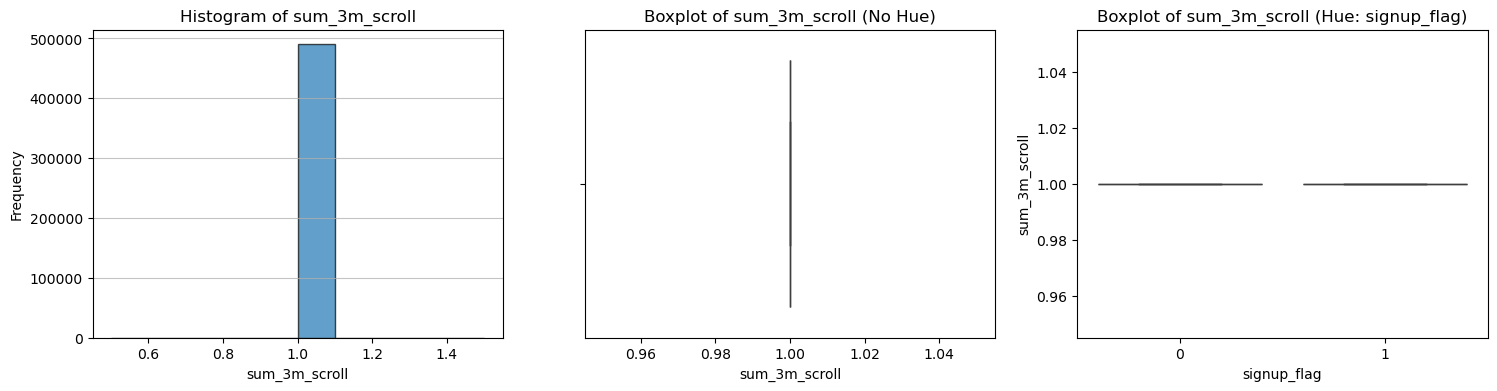

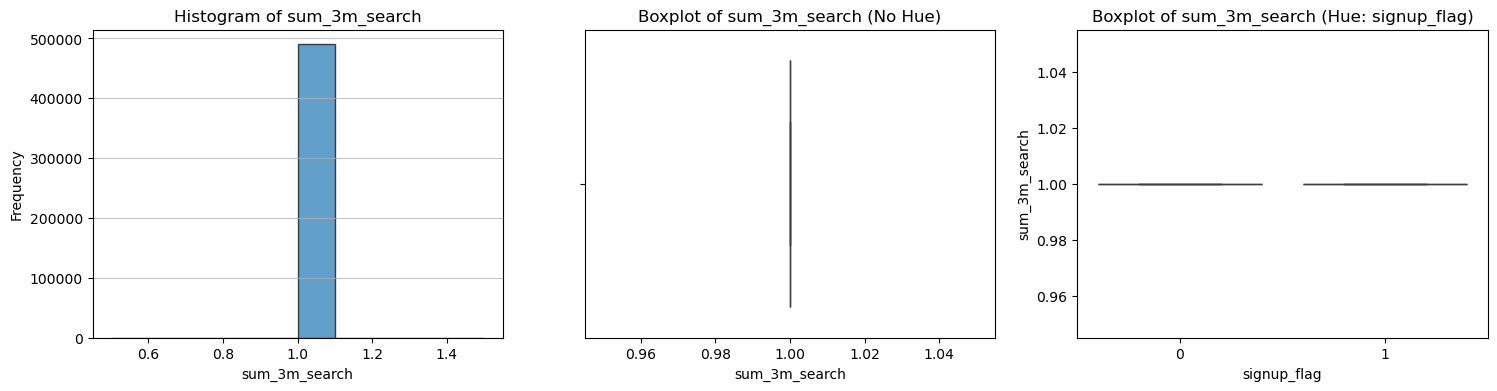

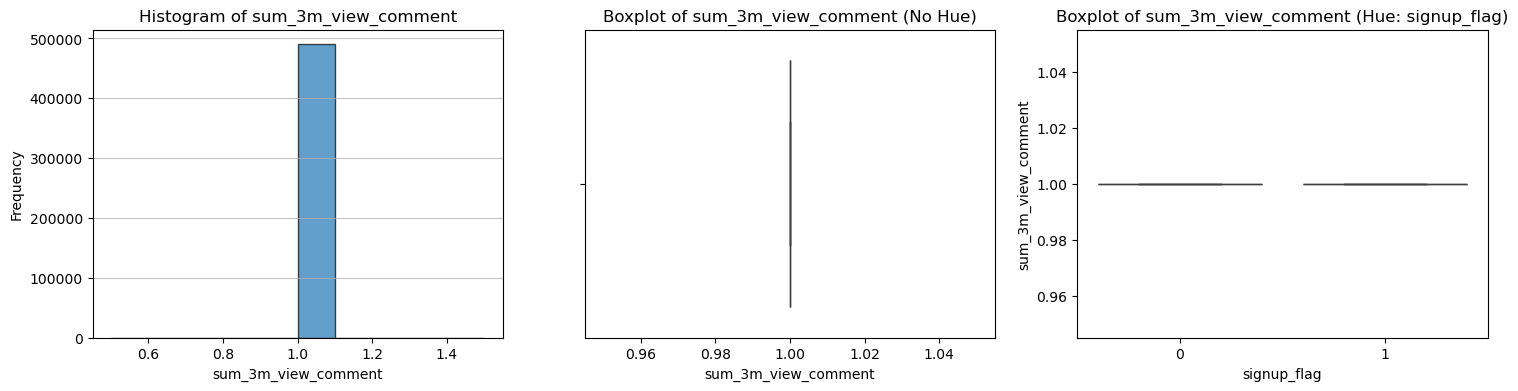

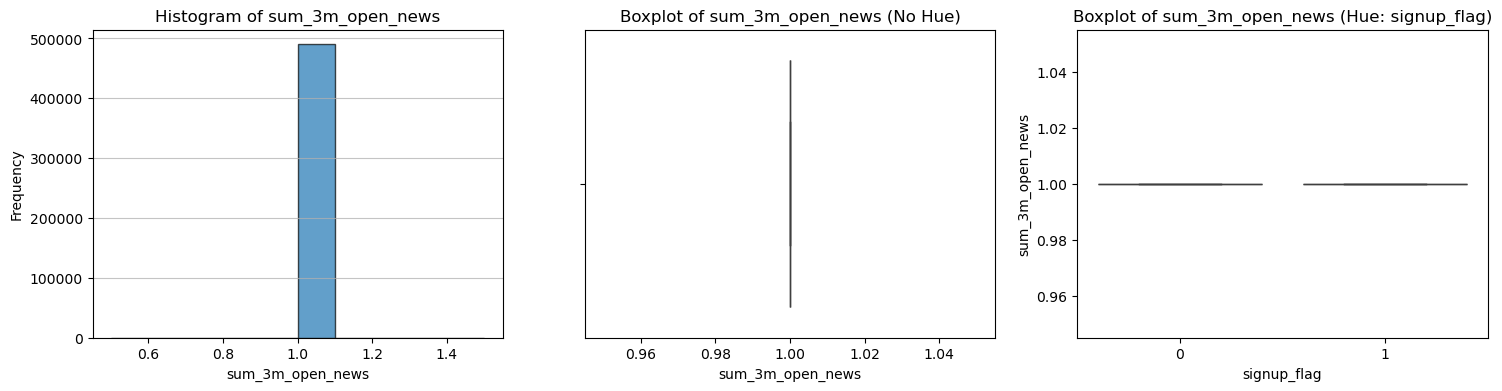

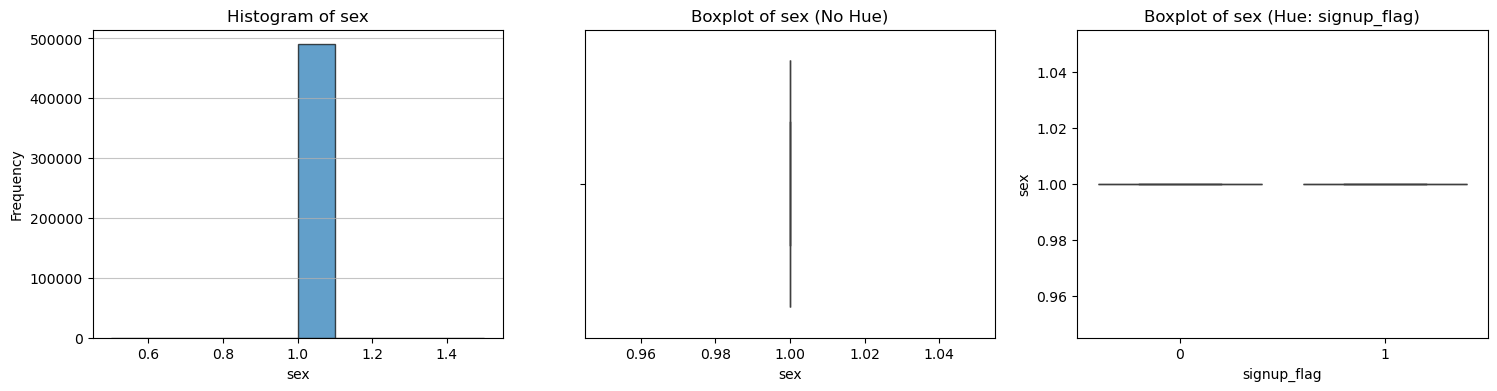

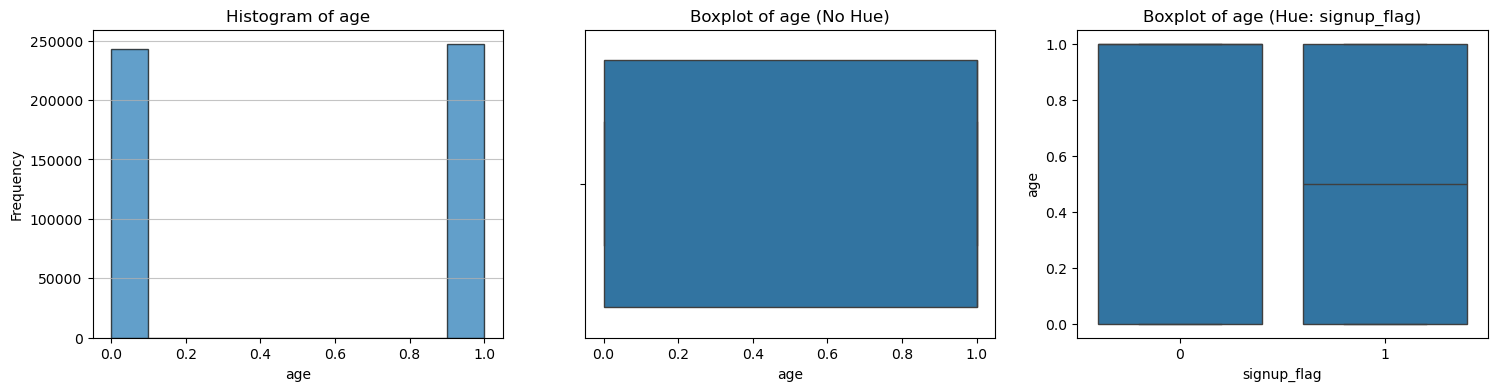

In [224]:
for column_name in num_col:
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 4))
    
    # Create a histogram
    ax1.hist(df[column_name], bins=10, edgecolor='black', alpha=0.7)
    ax1.set_title(f'Histogram of {column_name}')
    ax1.set_xlabel(column_name)
    ax1.set_ylabel('Frequency')
    ax1.grid(axis='y', alpha=0.75)
    
    # Create a boxplot without hue
    sns.boxplot(x=df[column_name], ax=ax2)
    ax2.set_title(f'Boxplot of {column_name} (No Hue)')
    ax2.set_xlabel(column_name)
    
    # Create a boxplot with hue='signup_flag'
    sns.boxplot(x='signup_flag', y=column_name, data=df, ax=ax3)
    ax3.set_title(f'Boxplot of {column_name} (Hue: signup_flag)')
    ax3.set_xlabel('signup_flag')
    ax3.set_ylabel(column_name)
    
    plt.show()

correlation

In [225]:
# check correlation

In [226]:
corr = df.corr()

<Axes: >

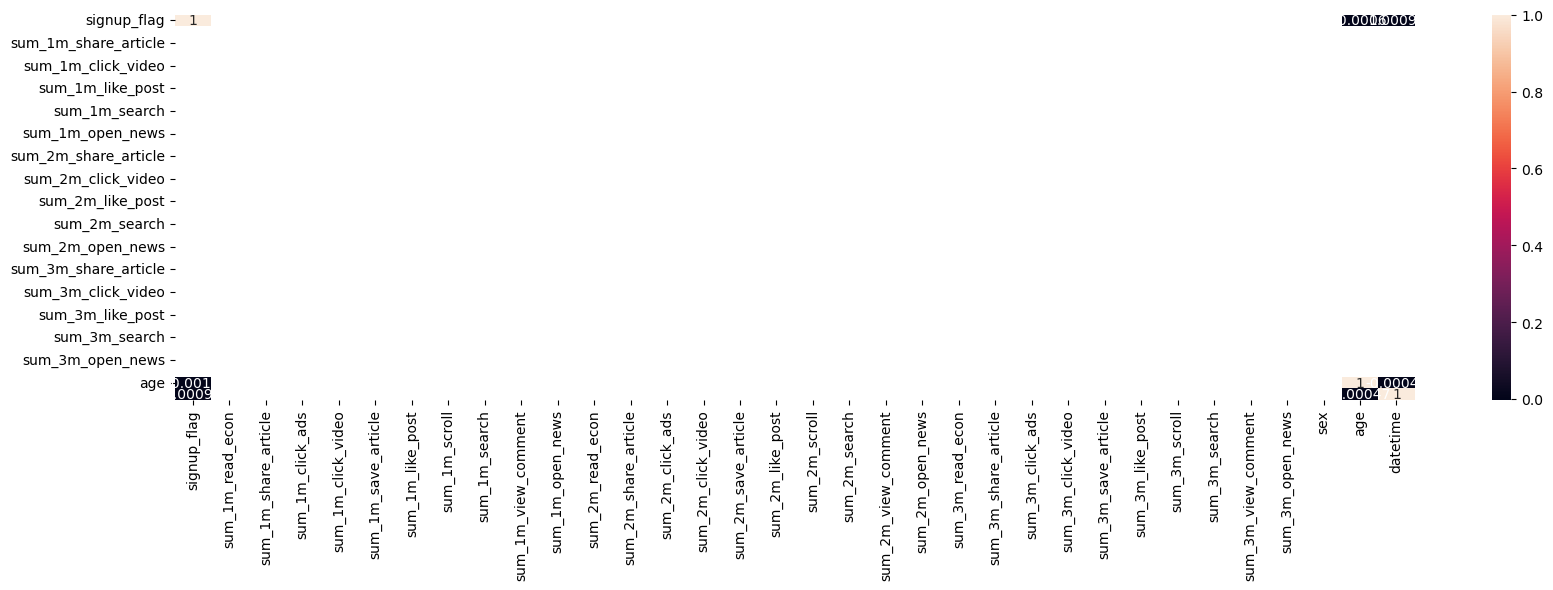

In [227]:
fig, ax = plt.subplots(figsize=(20, 5))
sns.heatmap(corr, annot=True, ax=ax)

In [228]:
corr_signup_table = corr['signup_flag'].sort_values(ascending=False)

In [229]:
corr_signup_table

signup_flag             1.000000
datetime                0.000908
age                    -0.001574
sum_1m_read_econ             NaN
sum_1m_share_article         NaN
sum_1m_click_ads             NaN
sum_1m_click_video           NaN
sum_1m_save_article          NaN
sum_1m_like_post             NaN
sum_1m_scroll                NaN
sum_1m_search                NaN
sum_1m_view_comment          NaN
sum_1m_open_news             NaN
sum_2m_read_econ             NaN
sum_2m_share_article         NaN
sum_2m_click_ads             NaN
sum_2m_click_video           NaN
sum_2m_save_article          NaN
sum_2m_like_post             NaN
sum_2m_scroll                NaN
sum_2m_search                NaN
sum_2m_view_comment          NaN
sum_2m_open_news             NaN
sum_3m_read_econ             NaN
sum_3m_share_article         NaN
sum_3m_click_ads             NaN
sum_3m_click_video           NaN
sum_3m_save_article          NaN
sum_3m_like_post             NaN
sum_3m_scroll                NaN
sum_3m_sea

In [230]:
corr_signup_abs_table = corr['signup_flag'].abs().sort_values(ascending=False)

In [231]:
corr_signup_abs_table

signup_flag             1.000000
age                     0.001574
datetime                0.000908
sum_1m_read_econ             NaN
sum_1m_share_article         NaN
sum_1m_click_ads             NaN
sum_1m_click_video           NaN
sum_1m_save_article          NaN
sum_1m_like_post             NaN
sum_1m_scroll                NaN
sum_1m_search                NaN
sum_1m_view_comment          NaN
sum_1m_open_news             NaN
sum_2m_read_econ             NaN
sum_2m_share_article         NaN
sum_2m_click_ads             NaN
sum_2m_click_video           NaN
sum_2m_save_article          NaN
sum_2m_like_post             NaN
sum_2m_scroll                NaN
sum_2m_search                NaN
sum_2m_view_comment          NaN
sum_2m_open_news             NaN
sum_3m_read_econ             NaN
sum_3m_share_article         NaN
sum_3m_click_ads             NaN
sum_3m_click_video           NaN
sum_3m_save_article          NaN
sum_3m_like_post             NaN
sum_3m_scroll                NaN
sum_3m_sea

# 4. Model

train test split

In [ ]:
df.shape

In [ ]:
df.sort_values(by='datetime', inplace=True)

In [ ]:
df.head()

In [ ]:
train_df = df[(df['datetime'] >= '2023-04-30') & (df['datetime'] <= '2023-08-31')]

val_df = df[(df['datetime'] == '2023-09-30')]

test_df = df[(df['datetime'] == '2023-10-31')]

In [ ]:
X_train = train_df.drop(columns=['signup_flag', 'datetime'])
y_train = train_df['signup_flag']

X_val = val_df.drop(columns=['signup_flag', 'datetime'])
y_val = val_df['signup_flag']

X_test = test_df.drop(columns=['signup_flag', 'datetime'])
y_test = test_df['signup_flag']

In [ ]:
print(X_train.shape)
print(y_train.shape)

print(X_val.shape)
print(y_val.shape)

print(X_test.shape)
print(y_test.shape)

In [ ]:
y_train.value_counts()

In [ ]:
y_val.value_counts()

In [ ]:
y_test.value_counts()

In [ ]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt


# Create a logistic regression model
model = LogisticRegression(max_iter=1000)

# Fit the model to the training data
model.fit(X_train, y_train)

# Predict the probabilities for the positive class
y_probs = model.predict_proba(X_test)[:, 1]

# Calculate the AUC-ROC
auc = roc_auc_score(y_test, y_probs)
print(f'AUC-ROC: {auc:.2f}')

# Plot the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
plt.plot(fpr, tpr, label=f'Logistic Regression (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()

In [ ]:
***

over sampling

In [ ]:
adasyn = ADASYN(random_state=42)
X_train_adasyn, y_train_adasyn = adasyn.fit_resample(X_train, y_train)

In [ ]:
X_train_adasyn.shape

In [ ]:
y_train_adasyn.shape

predicts only 1

In [ ]:
dummy_all_signup = DummyClassifier(strategy='constant', constant=1)

In [ ]:
dummy_all_signup.fit(X_train_adasyn, y_train_adasyn)

predicts only 0

In [ ]:
dummy_all_not_signup = DummyClassifier(strategy='constant', constant=0)

In [ ]:
dummy_all_not_signup.fit(X_train_adasyn, y_train_adasyn)

model: lightgbm

In [ ]:
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit, RandomizedSearchCV
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression

In [ ]:
lgbm_params = {
    'n_estimators': [1000],
}

In [ ]:
lgbm = LGBMClassifier(random_state=42)
tscv = TimeSeriesSplit(n_splits=3)

In [ ]:
lgbm_grid_search = GridSearchCV(
    estimator=lgbm,
    param_grid=lgbm_params,
    cv=tscv,
    scoring='roc_auc',
    n_jobs=-1
)

In [ ]:
lgbm_grid_search.fit(X_train_adasyn, y_train_adasyn)

In [ ]:
lgbm_grid_search.best_score_

In [ ]:
lgbm_grid_search.best_estimator_

In [ ]:
***

# 5. Result (precision/recall/AUC-ROC)

In [ ]:
models = {
    'Dummy Model (All Signup)': dummy_all_signup,
    'Dummy Model (All Not Signup)': dummy_all_not_signup,
    'XGBoost (SMOTE)': xgb_smote,
    'LightGBM (ADASYN)': lgbm_adasyn
}

In [ ]:
summary_metrics = pd.DataFrame(columns=['Model', 'Observation', 'TP', 'TN', 'FP', 'FN', 'Precision', 'Recall', 'AUCROC'])

In [ ]:
for model_name, model in models.items():
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    tp = cm[1, 1]
    tn = cm[0, 0]
    fp = cm[0, 1]
    fn = cm[1, 0]
    recall = tp / (tp + fn)
    precision = tp / (tp + fp)
    auc_roc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

    model_summary = pd.DataFrame({
        'Model': [model_name],
        'Observation': [len(y_test)],
        'TP': [tp],
        'TN': [tn],
        'FP': [fp],
        'FN': [fn],
        'Precision': [precision],
        'Recall': [recall],
        'AUCROC': [auc_roc]
    })

    summary_metrics = pd.concat([summary_metrics, model_summary], ignore_index=True)

In [ ]:
summary_metrics